<a href="https://colab.research.google.com/github/samanthajmichael/machine_learning/blob/main/notebooks/Consumer_Complaints.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
%%capture
#!pip uninstall -y nltk
#!pip install nltk

In [42]:
import nltk
print("Downloading required NLTK data...")
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('vader_lexicon')

import pandas as pd
import numpy as np
from datetime import datetime
from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
pd.options.mode.chained_assignment = None

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Load Data

In [24]:
def load_github_data(url):
    """
    Load data from GitHub raw content URL
    Example URL: https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv
    """
    return pd.read_csv(url)

In [25]:
url = "https://raw.githubusercontent.com/samanthajmichael/machine_learning/main/data/complaints.csv"
df = pd.read_csv(url)

In [26]:
df.dtypes

,0
Date received,object
Product,object
Sub-product,object
Issue,object
Sub-issue,object
Consumer complaint narrative,object
Company public response,object
Company,object
State,object
ZIP code,object


In [27]:
print(df['Date received'].head())

0    10/19/24
1    09/01/24
2    10/18/24
3    08/18/24
4    10/19/24
Name: Date received, dtype: object


Field name| Description| Data type| Notes
----------|------------|---------|-------|
Date received| The date the CFPB received the complaint| date & time|
Product| The type of product the consumer identified in the complaint| plain text| This field is a categorical variable.
Sub-product| The type of sub-product the consumer identified in the complaint| plain text| This field is a categorical variable. Not all Products have Sub-products.
Issue| The issue the consumer identified in the complaint| plain text| This field is a categorical variable. Possible values are dependent on Product.
Sub-issue| The sub-issue the consumer identified in the complaint| plain text| This field is a categorical variable. Possible values are dependent on product and issue. Not all Issues have corresponding Sub-issues.
Consumer complaint narrative| Consumer complaint narrative is the consumer-submitted description of "what happened" from the complaint. Consumers must opt-in to share their narrative. We will not publish the narrative unless the consumer consents, and consumers can opt-out at any time. The CFPB takes reasonable steps to scrub personal information from each complaint that could be used to identify the consumer.| plain text| Consumers' descriptions of what happened are included if consumers consent to publishing the description and after we take steps to remove personal information."
Company public response| The company's optional, public-facing response to a consumer's complaint. Companies can choose to select a response from a pre-set list of options that will be posted on the public database. For example, "Company believes complaint is the result of an isolated error."| plain text| Companies' public-facing responses to complaints are included if companies choose to publish one. Companies may select a public response from a set list of options as soon as they respond to the complaint, but no later than 180 days after the complaint was sent to the company for response.
Company| The complaint is about this company| plain text| This field is a categorical variable.
State| The state of the mailing address provided by the consumer| plain text| This field is a categorical variable.
ZIP code| The mailing ZIP code provided by the consumer| plain text| The mailing ZIP code provided by the consumer. The 5-digit United States Postal Service ZIP code will be published where provided unless the consumer lived in a ZIP code aligned to a United States Census Bureau ZIP Code Tabulation Area (ZCTA) with fewer than 20,000 people and consented to publication of their complaint narrative. In those cases, where the Census ZCTA had fewer than 20,000 people, the 3-digit ZIP code will be published if the 3-digit ZCTA has more than 20,000 people. Otherwise, no ZIP code will be published.
Tags| Data that supports easier searching and sorting of complaints submitted by or on behalf of consumers. For example, complaints where the submitter reports the age of the consumer as 62 years or older are tagged, 'Older American.' Complaints submitted by or on behalf of a servicemember or the spouse or dependent of a servicemember are tagged, 'Servicemember.' Servicemember includes anyone who is active duty, National Guard, or Reservist, as well as anyone who previously served and is a Veteran or retiree.| plain text|
Consumer consent provided?| Identifies whether the consumer opted in to publish their complaint narrative. We do not publish the narrative unless the consumer consents and consumers can opt-out at any time.| plain text| This field shows whether a consumer provided consent to publish their complaint narrative, as listed below: Consent provided: Consumer opted in to share their complaint narrative. Data populates in this field 60 days after the complaint was sent to the company for response or after the company provides an optional company public response – whichever comes first, and after steps have been taken to scrub personal information from the complaint narrative. Consent not provided: Consumer did not opt-in to publish their complaint narrative. Data populates in this field 60 days after the complaint was sent to the company for response or after the company provides an optional company public response – whichever comes first. Consent withdrawn: Consumer opted in to publish their complaint narrative and later withdrew their consent. N/A: Consumers did not have the option to publish their consumer complaint narrative or the complaint was received before March 19, 2015. Data populates in this field immediately. Other: Complaint does not meet criteria for narrative publication. Blanks appear until at least 60 days after the complaint is sent to the company for response or until the company provides an optional company public response – whichever comes first.
Submitted via| How the complaint was submitted to the CFPB| plain text| This field is a categorical variable.
Date sent to company| The date the CFPB sent the complaint to the company| date & time|
Company response to consumer| This is how the company responded. For example, "Closed with explanation."| plain text| This field is a categorical variable.
Timely response?| Whether the company gave a timely response| plain text| yes/no
Consumer disputed?| Whether the consumer disputed the company's response| plain text| Yes No N/A: The Bureau discontinued the consumer dispute option on April 24, 2017.
Complaint ID| The unique identification number for a complaint| number|

In [28]:
df = df.copy(deep=True)

In [29]:
df = df.rename(columns={'Date received': 'Date', 'Consumer complaint narrative': 'Complaint'})

In [30]:
df = df.loc[(df['Product']=='Bank account or service') | (df['Product']=='Checking or savings account') | (df['Product']=='Money transfers') | (df['Product']=='Money transfer, virtual currency, or money service')]

In [31]:
df=df[['Date', 'Product', 'Complaint']]

In [32]:
df = df.set_index(pd.to_datetime(df['Date'], format='mixed'))

In [33]:
df.drop(['Date'], axis=1, inplace=True)

In [34]:
df.head()

,Product,Complaint
Date,,
2024-10-19,Checking or savings account,NaN
2024-10-18,Checking or savings account,Try to use my card and got declined and call t...
2024-08-18,Checking or savings account,W. F employees opened both personal and busine...
2024-08-18,Checking or savings account,My. Wells. Fargo. Acount. Was. Hacked. Several...
2024-10-18,Checking or savings account,I receive direct deposits from my job every Fr...


In [35]:
df.describe()

,Product,Complaint
count,50266,19615
unique,4,19592
top,Checking or savings account,Excessive overdraft fees
freq,31879,3


In [36]:
df.isnull().sum()

,0
Product,0
Complaint,30651


In [37]:
%%capture
!pip install symspellpy

In [45]:
import pandas as pd
import numpy as np
from textblob import TextBlob
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
import re
import pkg_resources
from symspellpy import SymSpell, Verbosity
from pathlib import Path

def initialize_symspell():
    sym_spell = SymSpell(max_dictionary_edit_distance=2, prefix_length=7)
    dictionary_path = pkg_resources.resource_filename(
        "symspellpy", "frequency_dictionary_en_82_765.txt")
    sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)
    return sym_spell

def preprocess_text(text, sym_spell):
    """
    Clean and preprocess text with SymSpell correction
    """
    try:
        # Remove Wells Fargo completely before other processing
        text = str(text).lower()

        # Comprehensive Wells Fargo removal patterns
        wells_fargo_patterns = [
            r'well[s]?\s*f[a-z]*go',  # wells fargo, wellfargo, well fargo
            r'f[a-z]*go\s*well[s]?',  # fargowell, fargo wells
            r'\bf[a-z]*go\b',         # fargo
            r'\bwf\b'                 # wf

        ]

        # Apply each pattern
        for pattern in wells_fargo_patterns:
            text = re.sub(pattern, '', text, flags=re.IGNORECASE)

        # Initial cleaning
        text = str(text).lower()
        text = re.sub('[Xx]+', '', text)
        text = re.sub(r'[^a-z\s]', '', text)
        text = re.sub(r'\s+', ' ', text).strip()

        # Spell correction
        suggestions = sym_spell.lookup_compound(text, max_edit_distance=2)
        if suggestions:
            text = suggestions[0].term

        # Tokenization and stop word removal
        tokens = word_tokenize(text)
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words]

        # Lemmatization
        lemmatizer = WordNetLemmatizer()
        tokens = [lemmatizer.lemmatize(token) for token in tokens]

        return ' '.join(tokens)
    except Exception as e:
        print(f"Error processing text: {e}")
        return ""

def calculate_sentiment_scores(text):
    """
    Calculate sentiment scores using both TextBlob and NLTK
    """
    # TextBlob sentiment
    blob_sentiment = TextBlob(text).sentiment.polarity

    # NLTK VADER sentiment
    sia = SentimentIntensityAnalyzer()
    nltk_scores = sia.polarity_scores(text)

    return blob_sentiment, nltk_scores['compound']

def analyze_complaints(input_df, text_column='Complaint'):
    """
    Analyze complaints and return enriched dataframe with sentiment scores
    """
    sym_spell = initialize_symspell()
    df = input_df.copy(deep=True)
    mask = df[text_column].notna() & (df[text_column].str.strip() != '')
    df = df.loc[mask].copy()

    print("\nPreprocessing text...")
    df['cleaned_text'] = df[text_column].apply(lambda x: preprocess_text(x, sym_spell))

    print("Calculating sentiment scores...")
    sentiments = df['cleaned_text'].apply(calculate_sentiment_scores)
    df['textblob_sentiment'] = sentiments.apply(lambda x: x[0])
    df['nltk_sentiment'] = sentiments.apply(lambda x: x[1])

    # Calculate daily aggregates
    daily_sentiment = df.groupby('Date').agg({
        'textblob_sentiment': ['mean', 'std', 'count'],
        'nltk_sentiment': ['mean', 'std'],
        text_column: 'count'
    }).round(4)

    daily_sentiment.columns = [
        'textblob_avg',
        'textblob_std',
        'sentiment_count',
        'nltk_avg',
        'nltk_std',
        'total_complaints'
    ]

    daily_sentiment['textblob_ci'] = (
        1.96 * daily_sentiment['textblob_std'] /
        np.sqrt(daily_sentiment['sentiment_count'])
    ).round(4)

    daily_sentiment['nltk_ci'] = (
        1.96 * daily_sentiment['nltk_std'] /
        np.sqrt(daily_sentiment['sentiment_count'])
    ).round(4)

    correlation = df[['textblob_sentiment', 'nltk_sentiment']].corr().iloc[0,1]
    print(f"\nCorrelation between TextBlob and NLTK sentiment scores: {correlation:.4f}")

    return df, daily_sentiment

In [46]:
daily_sentiment, processed_df = analyze_complaints(df)
if daily_sentiment is not None:
    print("Analysis completed successfully")
    print(daily_sentiment.head())
else:
    print("Analysis failed")


Preprocessing text...
Calculating sentiment scores...

Correlation between TextBlob and NLTK sentiment scores: 0.2418
Analysis completed successfully
                                Product  \
Date                                      
2024-10-18  Checking or savings account   
2024-08-18  Checking or savings account   
2024-08-18  Checking or savings account   
2024-10-18  Checking or savings account   
2024-08-16  Checking or savings account   

                                                    Complaint  \
Date                                                            
2024-10-18  Try to use my card and got declined and call t...   
2024-08-18  W. F employees opened both personal and busine...   
2024-08-18  My. Wells. Fargo. Acount. Was. Hacked. Several...   
2024-10-18  I receive direct deposits from my job every Fr...   
2024-08-16  I was exposed to a fradulent activity that cos...   

                                                 cleaned_text  \
Date                      

In [47]:
# View the results
print("\nFirst few rows of monthly sentiment analysis:")
print(daily_sentiment.head())


First few rows of monthly sentiment analysis:
                                Product  \
Date                                      
2024-10-18  Checking or savings account   
2024-08-18  Checking or savings account   
2024-08-18  Checking or savings account   
2024-10-18  Checking or savings account   
2024-08-16  Checking or savings account   

                                                    Complaint  \
Date                                                            
2024-10-18  Try to use my card and got declined and call t...   
2024-08-18  W. F employees opened both personal and busine...   
2024-08-18  My. Wells. Fargo. Acount. Was. Hacked. Several...   
2024-10-18  I receive direct deposits from my job every Fr...   
2024-08-16  I was exposed to a fradulent activity that cos...   

                                                 cleaned_text  \
Date                                                            
2024-10-18  try use card got declined call bank said accou...   


In [48]:
daily_sentiment.to_csv('daily_sentiment.csv')

In [ ]:
# def plot_sentiment_by_year(monthly_sentiment_df):
#     """
#     Create a visualization of sentiment trends by month for each year
#     """
#     # Convert index to datetime for easier manipulation
#     df_plot = monthly_sentiment_df.reset_index()

#     # Split the 'month' column into year and month
#     df_plot[['year', 'month']] = df_plot['month'].str.split('-', expand=True)
#     df_plot['month_num'] = df_plot['month'].astype(int)
#     df_plot['year'] = df_plot['year'].astype(int)

#     # Create the visualization
#     plt.figure(figsize=(15, 8))

#     # Plot lines for each year
#     for year in sorted(df_plot['year'].unique()):
#         year_data = df_plot[df_plot['year'] == year]
#         plt.plot(year_data['month_num'],
#                 year_data['avg_sentiment'],
#                 marker='o',
#                 label=str(year),
#                 linewidth=2)

#     # Customize the plot
#     plt.title('Average Sentiment Score by Month and Year', fontsize=14, pad=20)
#     plt.xlabel('Month', fontsize=12)
#     plt.ylabel('Average Sentiment Score', fontsize=12)

#     # Set x-axis ticks to show all months
#     plt.xticks(range(1, 13),
#                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
#                rotation=45)

#     # Add grid for better readability
#     plt.grid(True, linestyle='--', alpha=0.7)

#     # Add legend
#     plt.legend(title='Year', bbox_to_anchor=(1.05, 1), loc='upper left')

#     # Adjust layout to prevent cutting off labels
#     plt.tight_layout()

#     return plt.gcf()

In [ ]:
# def create_monthly_heatmap(monthly_sentiment_df):
#     """
#     Create a heatmap of sentiment scores by month and year
#     """
#     # Prepare data for heatmap
#     df_heat = monthly_sentiment_df.reset_index()
#     df_heat[['year', 'month']] = df_heat['month'].str.split('-', expand=True)
#     df_heat['month_num'] = df_heat['month'].astype(int)
#     df_heat['year'] = df_heat['year'].astype(int)

#     # Pivot data for heatmap
#     pivot_data = df_heat.pivot(index='year',
#                               columns='month_num',
#                               values='avg_sentiment')

#     # Create heatmap
#     plt.figure(figsize=(15, 8))
#     sns.heatmap(pivot_data,
#                 cmap='RdYlBu',
#                 center=0,
#                 annot=True,
#                 fmt='.3f',
#                 cbar_kws={'label': 'Average Sentiment Score'})

#     # Customize the plot
#     plt.title('Sentiment Scores Heatmap by Month and Year', fontsize=14, pad=20)
#     plt.xlabel('Month', fontsize=12)
#     plt.ylabel('Year', fontsize=12)

#     # Set x-axis labels to month names
#     plt.xticks(range(12),
#                ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'],
#                rotation=45)

#     plt.tight_layout()

#     return plt.gcf()

In [ ]:
# # Create both visualizations
# def plot_sentiment_analysis(monthly_sentiment_df):
#     """
#     Create both line plot and heatmap visualizations
#     """
#     # Create line plot
#     fig1 = plot_sentiment_by_year(monthly_sentiment_df)

#     # Create heatmap
#     fig2 = create_monthly_heatmap(monthly_sentiment_df)

#     return fig1, fig2

ValueError: Index contains duplicate entries, cannot reshape

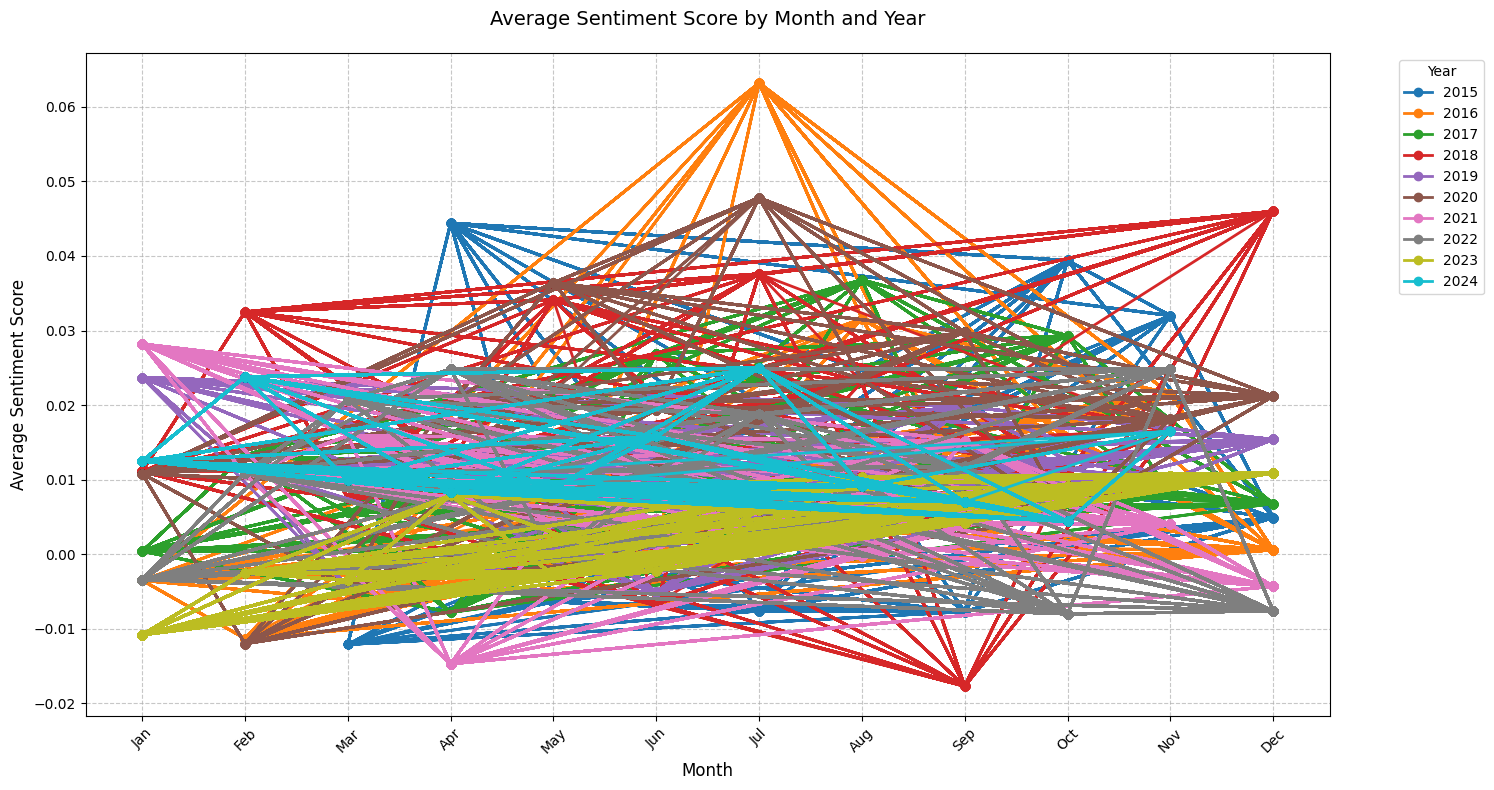

In [ ]:
# fig1, fig2 = plot_sentiment_analysis(monthly_sentiment)
# plt.show()

In [ ]:
# from matplotlib.ticker import MaxNLocator

# def plot_sentiment_by_separate_years(monthly_sentiment_df):
#     """
#     Create separate subplot visualizations for each year's sentiment trends
#     """
#     # Prepare the data
#     df_plot = monthly_sentiment_df.reset_index()
#     df_plot[['year', 'month']] = df_plot['month'].str.split('-', expand=True)
#     df_plot['month_num'] = df_plot['month'].astype(int)
#     df_plot['year'] = df_plot['year'].astype(int)

#     # Get unique years and calculate subplot layout
#     years = sorted(df_plot['year'].unique())
#     n_years = len(years)
#     n_cols = 2  # Number of columns in the subplot grid
#     n_rows = (n_years + 1) // 2  # Number of rows needed (rounded up)

#     # Create figure and subplots
#     fig = plt.figure(figsize=(15, 5*n_rows))

#     # Month names for x-axis
#     month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
#                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

#     # Plot each year
#     for idx, year in enumerate(years):
#         # Create subplot
#         ax = plt.subplot(n_rows, n_cols, idx + 1)

#         # Get data for this year
#         year_data = df_plot[df_plot['year'] == year].copy()

#         # Sort by month number
#         year_data = year_data.sort_values('month_num')

#         # Plot the line
#         plt.plot(year_data['month_num'],
#                 year_data['avg_sentiment'],
#                 marker='o',
#                 linewidth=2,
#                 color='#1f77b4')

#         # Add confidence interval if available
#         if 'confidence_interval' in year_data.columns:
#             plt.fill_between(year_data['month_num'],
#                            year_data['avg_sentiment'] - year_data['confidence_interval'],
#                            year_data['avg_sentiment'] + year_data['confidence_interval'],
#                            alpha=0.2,
#                            color='#1f77b4')

#         # Customize subplot
#         plt.title(f'Sentiment Trends - {year}', fontsize=12, pad=10)
#         plt.grid(True, linestyle='--', alpha=0.7)

#         # Set x-axis ticks to show all months
#         plt.xticks(range(1, 13), month_names, rotation=45)

#         # Set y-axis limits to be consistent across subplots
#         all_sentiments = df_plot['avg_sentiment']
#         plt.ylim(all_sentiments.min() - 0.1, all_sentiments.max() + 0.1)

#         # Add number of complaints as text annotations
#         for i, row in year_data.iterrows():
#             plt.annotate(f'n={int(row["total_complaints"])}',
#                         (row['month_num'], row['avg_sentiment']),
#                         textcoords="offset points",
#                         xytext=(0,10),
#                         ha='center',
#                         fontsize=8)

#         # Only add ylabel for leftmost subplots
#         if idx % n_cols == 0:
#             plt.ylabel('Average Sentiment Score', fontsize=10)

#         # Only add xlabel for bottom subplots
#         if idx >= len(years) - n_cols:
#             plt.xlabel('Month', fontsize=10)

#     # Add overall title
#     plt.suptitle('Monthly Sentiment Trends by Year', fontsize=14, y=1.02)

#     # Adjust layout to prevent overlapping
#     plt.tight_layout()

#     return fig

# # Add a function to get basic statistics for each year
# def print_yearly_statistics(monthly_sentiment_df):
#     """
#     Print basic statistics for each year
#     """
#     df_stats = monthly_sentiment_df.reset_index()
#     df_stats[['year', 'month']] = df_stats['month'].str.split('-', expand=True)

#     yearly_stats = df_stats.groupby('year').agg({
#         'avg_sentiment': ['mean', 'min', 'max', 'std'],
#         'total_complaints': 'sum'
#     }).round(4)

#     yearly_stats.columns = ['Mean Sentiment', 'Min Sentiment',
#                           'Max Sentiment', 'Std Deviation',
#                           'Total Complaints']

#     return yearly_stats

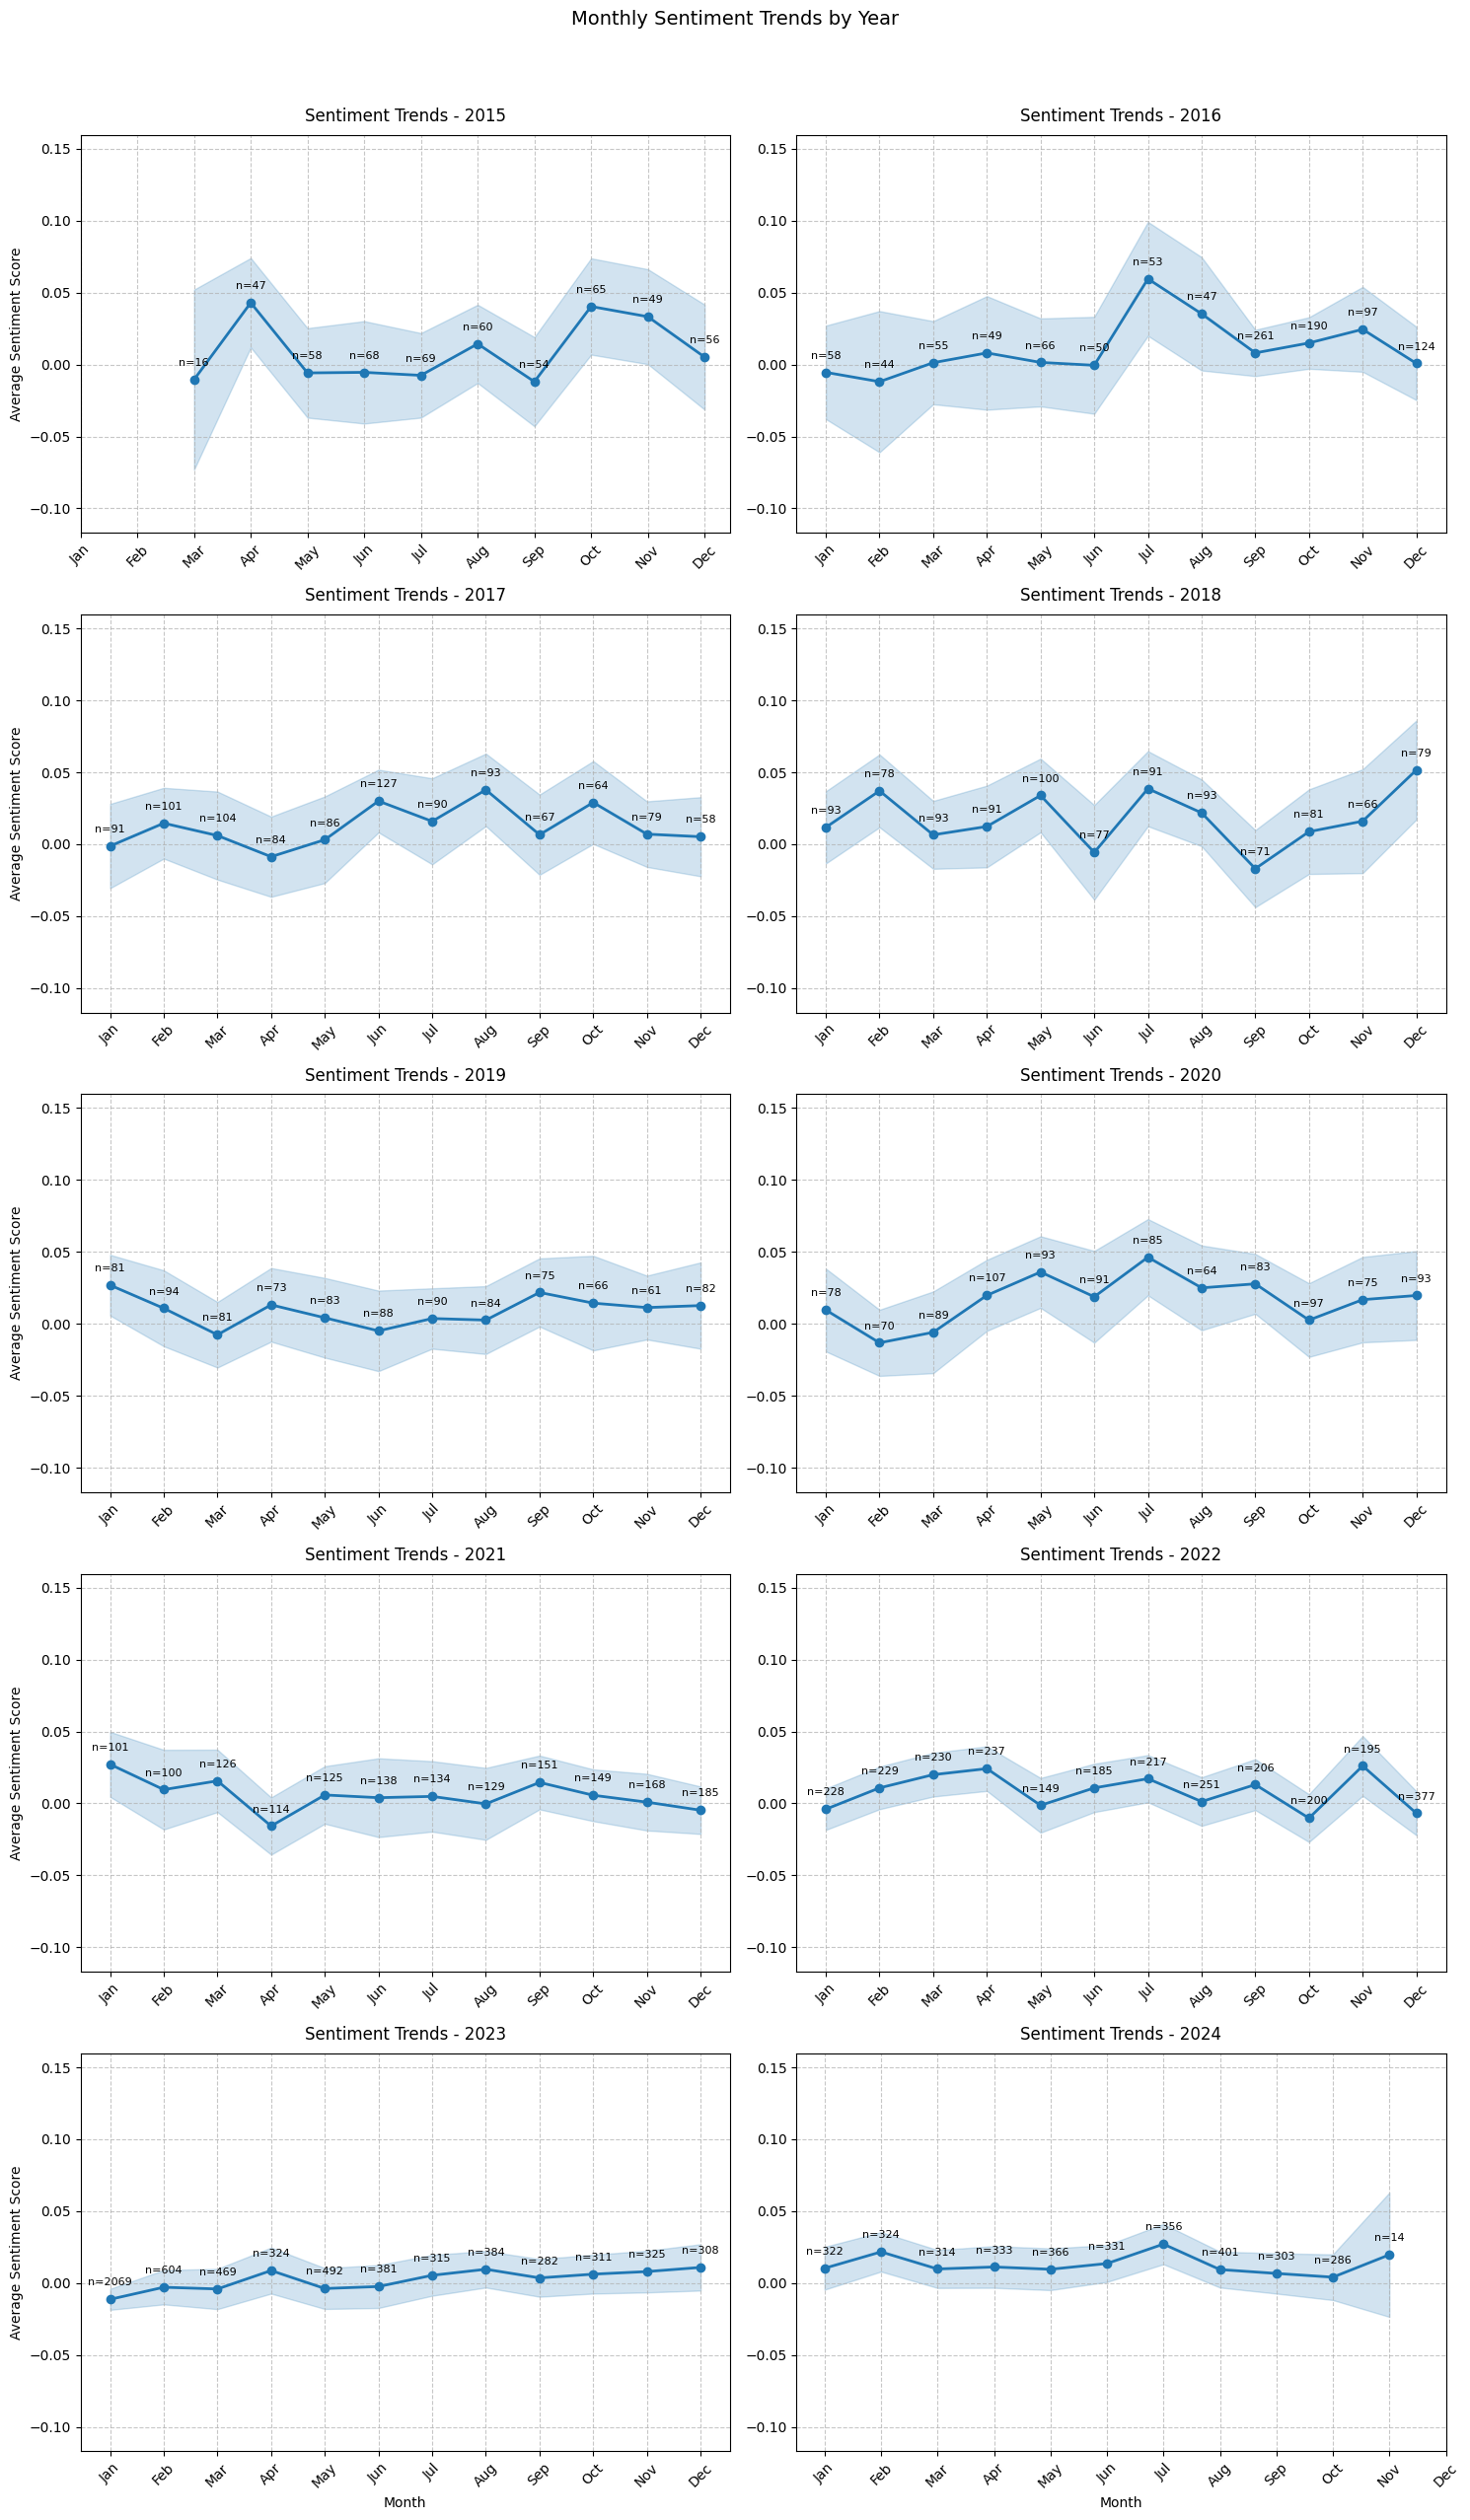

In [ ]:
# fig = plot_sentiment_by_separate_years(monthly_sentiment)
# plt.show()

In [ ]:
# yearly_stats = print_yearly_statistics(monthly_sentiment)
# print(yearly_stats)

      Mean Sentiment  Min Sentiment  Max Sentiment  Std Deviation  \
year                                                                
2015          0.0095        -0.0119         0.0430         0.0218   
2016          0.0114        -0.0119         0.0596         0.0200   
2017          0.0121        -0.0087         0.0378         0.0139   
2018          0.0180        -0.0170         0.0516         0.0197   
2019          0.0091        -0.0076         0.0269         0.0101   
2020          0.0169        -0.0132         0.0463         0.0168   
2021          0.0056        -0.0157         0.0272         0.0108   
2022          0.0084        -0.0102         0.0261         0.0124   
2023          0.0023        -0.0113         0.0109         0.0070   
2024          0.0130         0.0041         0.0271         0.0070   

      Total Complaints  
year                    
2015               542  
2016              1094  
2017              1044  
2018              1013  
2019               95